<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install requirements and mount correct folder

In [0]:
pip install fairseq sacrebleu sentencepiece torch

     |████████████████████████████████| 307kB 6.2MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 1.0MB 22.2MB/s 
     |████████████████████████████████| 17.1MB 201kB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2015398 sha256=67a8c4f5bec462c341f96bf82972534268bcfc83410dc6bb1f2a2ece03ba8663
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
Analysis     download-data.sh	     prepare-neen.sh  scripts
checkpoints  Ensembles		     prepare-sien.sh  sentence_level_bleu
configs      Ensembling		     README.md
data	     FLORES.ipynb	     removed
data-bin     prepare-monolingual.sh  reproduce.sh
/content/drive/My Drive/ConfidentMachineTranslation/flores


Testing models in Ensembles individually.

In [0]:
import glob
path = 'Ensembles/*'

for file in glob.glob(path):
    !fairseq-generate \
        data-bin/wiki_ne_en_bpe5000/ \
        --source-lang ne --target-lang en \
        --path $file \
        --beam 5 --lenpen 1.2 \
        --gen-subset test \
        --remove-bpe=sentencepiece \
        --sacrebleu --quiet

Namespace(beam=5, bpe=None, cpu=False, criterion='cross_entropy', data='data-bin/wiki_ne_en_bpe5000/', dataset_impl=None, decoding_format=None, diverse_beam_groups=-1, diverse_beam_strength=0.5, empty_cache_freq=0, force_anneal=None, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, gen_subset='test', iter_decode_eos_penalty=0.0, iter_decode_force_max_iter=False, iter_decode_max_iter=10, lazy_load=False, left_pad_source='True', left_pad_target='False', lenpen=1.2, load_alignments=False, log_format=None, log_interval=1000, lr_scheduler='fixed', lr_shrink=0.1, match_source_len=False, max_len_a=0, max_len_b=200, max_sentences=None, max_source_positions=1024, max_target_positions=1024, max_tokens=12000, memory_efficient_fp16=False, min_len=1, min_loss_scale=0.0001, model_overrides='{}', momentum=0.99, nbest=1, no_beamable_mm=False, no_early_stop=False, no_progress_bar=False, no_repeat_ngram_size=0, num_shards=1, num_workers=1, optimizer='nag', path='Ensembl

Using all models in Ensembles together


In [0]:
import glob
path = 'Ensembles/*'
ensemble_models = ""
for file in glob.glob(path):
  ensemble_models += file + ":"
ensemble_models = ensemble_models[:-1]

!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path $ensemble_models \
    --beam 5 --lenpen 1.2 \
    --gen-subset test \
    --remove-bpe=sentencepiece \
    --sacrebleu > sentence_level_bleu/testSet_BLEU.txt

Using the file generated above to get reference (input) and translated sentences along with logprob stats. 

In [0]:
from statistics import mean, median 

bleu_res = open("sentence_level_bleu/testSet_BLEU.txt", "r")
NMT_input = open("sentence_level_bleu/input_sentences.txt", "w")
NMT_output = open("sentence_level_bleu/translated_sentences.txt", "w")
Sentence_stats = open("sentence_level_bleu/logprob_statistics.txt", "w")

for line in bleu_res:
    if line.startswith("H-"):
        NMT_output.write(line.split("	")[2])
    elif line.startswith("T-"):
        NMT_input.write(line.split("	")[1])
    elif line.startswith("P-"):
        scores = [float(i) for i in line.split("\t")[1].split(" ")]
        Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+"\n")

NMT_input.close()
NMT_output.close()
Sentence_stats.close()

Now use the input and translated sentences files to get sentence level bleu

In [0]:
!fairseq-score --sys sentence_level_bleu/translated_sentences.txt --ref sentence_level_bleu/input_sentences.txt --sentence-bleu > sentence_level_bleu/scores.txt

Get all the plots now!

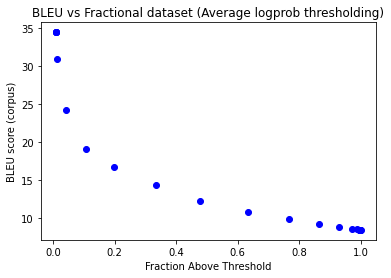

AUC for incuded fraction: 13.28226631393298


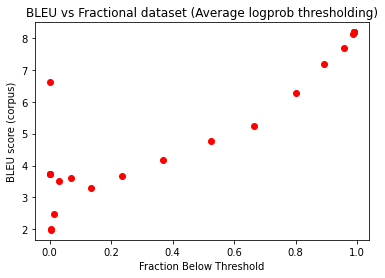

AUC for excluded fraction: 4.860996472663139


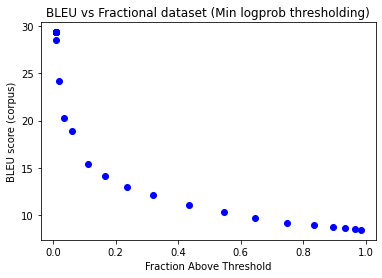

AUC for incuded fraction: 11.377984126984126


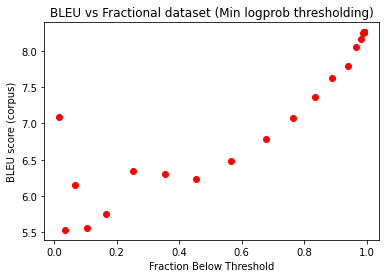

AUC for excluded fraction: 6.425319223985891


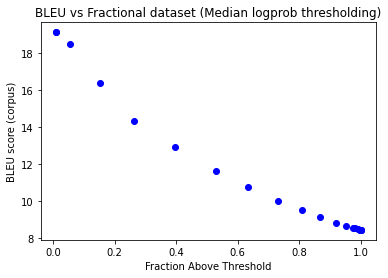

AUC for incuded fraction: 12.345848324514995


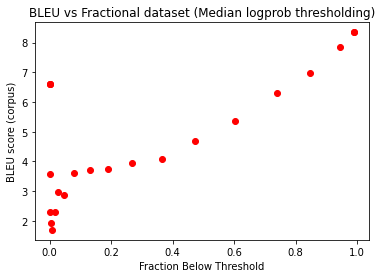

AUC for excluded fraction: 5.055984126984128


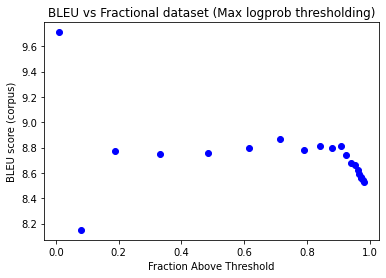

AUC for incuded fraction: 8.48884656084656


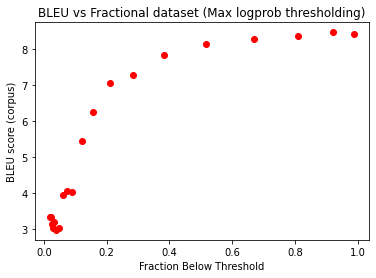

AUC for excluded fraction: 7.254017636684304


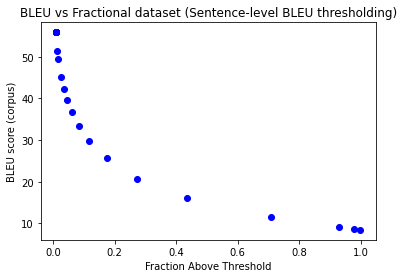

AUC for incuded fraction: 17.594610229276896


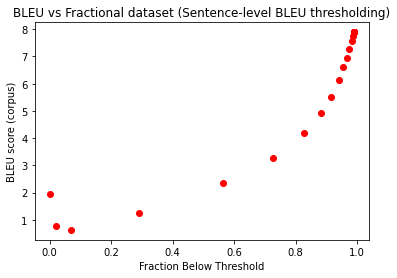

AUC for excluded fraction: 2.508703703703704


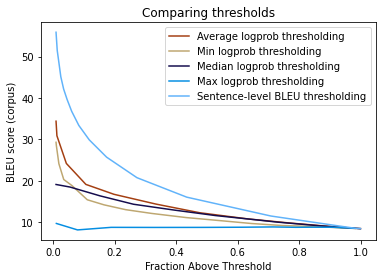

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from numpy import arange
import subprocess
import random


class Translation:
    def __init__ (self, ref, out, score):
        self.reference = ref
        self.translation = out
        self.score = score
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("sentence_level_bleu/temporary_reference_inclusion.txt", "w")
    temporary_output_inclusion = open("sentence_level_bleu/temporary_output_inclusion.txt", "w")

    temporary_reference_exclusion = open("sentence_level_bleu/temporary_reference_exclusion.txt", "w")
    temporary_output_exclusion = open("sentence_level_bleu/temporary_output_exclusion.txt", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys sentence_level_bleu/temporary_output_inclusion.txt --ref sentence_level_bleu/temporary_reference_inclusion.txt --sacrebleu > sentence_level_bleu/inclusion_result.txt
    !fairseq-score --sys sentence_level_bleu/temporary_output_exclusion.txt --ref sentence_level_bleu/temporary_reference_exclusion.txt --sacrebleu > sentence_level_bleu/exclusion_result.txt

    temporary_inclusion_result = open("sentence_level_bleu/inclusion_result.txt")
    temporary_exclusion_result = open("sentence_level_bleu/exclusion_result.txt")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


NMT_input = open("sentence_level_bleu/input_sentences.txt", "r")
NMT_output = open("sentence_level_bleu/translated_sentences.txt", "r")
Sentence_stats = open("sentence_level_bleu/logprob_statistics.txt", "r")
Sentence_bleu = open("sentence_level_bleu/scores.txt", "r")

next(Sentence_bleu)
files = [NMT_input, NMT_output, Sentence_stats, Sentence_bleu]
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = [float(i) for i in stats.strip("\n").split(" ")]
    stats.append(sentence_bleu)
    translations.append(Translation(reference, translation, stats))

stats_for_thresholding = [0,1,2,3,4] #average per token, min, median, max, sentence_bleu
num_to_thresh = {0:"Average logprob thresholding", 1: "Min logprob thresholding", 2:"Median logprob thresholding", 3:"Max logprob thresholding", 4:"Sentence-level BLEU thresholding"}
all_inclusion_scores = []
all_fractions_included = []

for stat in stats_for_thresholding:
    translations.sort(key=lambda x: x.score[stat], reverse=False)
    # print("Worst reference: " +translations[0].reference+" Worst translation: "+translations[0].translation)
    thresholds = []


    ##Trying to get approx 20 good thresholds for each case
    if stat == 0:
        thresholds = [i for i in arange(-1.5, 0, 0.07)]
    elif stat == 1:
        thresholds = [i for i in arange(-3.5, 0, 0.15)]
    elif stat == 2:
        thresholds = [i for i in arange(-1.5, 0, 0.07)]
    elif stat == 3:
        thresholds = [i for i in arange(-0.1, 0, 0.005)]
    elif stat == 4:
        thresholds = [i for i in arange(0, 70, 3)]

    inclusion_scores = []
    exclusion_scores = []
    fraction_included = []
    fraction_excluded = []

    for threshold in thresholds:
        split_index = 1 ## We always start at 1 so that the exclusion set is never empty. 
        while split_index < 0.99*len(translations) and translations[split_index].score[stat] < threshold:  ##0.95*len(translations) - to make sure the inclusion set always has a good number of examples
            split_index += 1
        exclusion, inclusion = compute_excluded_included_score(translations, split_index)
        inclusion_scores.append(inclusion)
        exclusion_scores.append(exclusion)
        fraction_included.append((len(translations) - split_index)/len(translations))
        fraction_excluded.append(split_index/len(translations))
    
    all_inclusion_scores.append(inclusion_scores)
    all_fractions_included.append(fraction_included)

    #########################   PLOTING   ################################
    plt.scatter(fraction_included, inclusion_scores, color= "blue")
    plt.xlabel('Fraction Above Threshold') 
    plt.ylabel('BLEU score (corpus)') 
    plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
    plt.show() 

    print('AUC for incuded fraction: {}'.format(auc(fraction_included, inclusion_scores)))

    plt.scatter(fraction_excluded, exclusion_scores, color= "red")
    plt.xlabel('Fraction Below Threshold') 
    plt.ylabel('BLEU score (corpus)') 
    plt.title('BLEU vs Fractional dataset ('+num_to_thresh[stat]+')') 
    plt.show()  

    print('AUC for excluded fraction: {}'.format(auc(fraction_excluded, exclusion_scores)))
    ####################################################################

plt.xlabel('Fraction Above Threshold') 
plt.ylabel('BLEU score (corpus)') 
plt.title('Comparing thresholds') 
for i in range(len(all_inclusion_scores)):
    r = random.random()
    b = random.random()
    g = random.random()
    c = (r, g, b)
    plt.plot(all_fractions_included[i], all_inclusion_scores[i], label = num_to_thresh[i], color=c)

plt.legend(loc="upper right")
plt.show()

NMT_input.close()
NMT_output.close()
Sentence_bleu.close()